# Train DECIPHER model with multi-slices

> (Estimated time: ~5 min with GPU)

In this vignette, we show how to train `DECIPHER` model on multiple spatial slices with batch effects.

1. Check data
2. Run DECIPHER
3. Visualize results

In [1]:
import scanpy as sc

from decipher import DECIPHER
from decipher.utils import scanpy_viz, gex_embedding

/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/cudf/utils/gpu_utils.py:149: UserWarning: No NVIDIA GPU detected
  warnings.warn("No NVIDIA GPU detected")
2025-07-11 15:54:10.623 | WARNING  | decipher.utils:<module>:34 - Rapids not avaliable, use Scanpy


In [2]:
sc.set_figure_params(dpi=80)

## Step 1: Check data

Here we use two simulation slices as an example, you can download them from Google Drive ([slice1](https://drive.google.com/file/d/1-J5YEkhujw1c67VkU1XJYsUonlS2kbZ5/view?usp=sharing), [slice2](https://drive.google.com/file/d/18j8IuiNtvrDj4D7m9fvWAiCDnPmHHfHq/view?usp=sharing))

In [3]:
slice1 = sc.read_h5ad('./slice1.h5ad')
slice2 = sc.read_h5ad('./slice2.h5ad')
adata = slice1.concatenate(slice2, batch_key='slice')

/tmp/ipykernel_2528240/665345369.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = slice1.concatenate(slice2, batch_key='slice')


These two slices share the same cell types:
- T cell
- B cell
- Monocyte

They also share the same spatial patterns:
- region 1: T cell & Monocyte mixed
- region 2: T cell only
- region 3: T cell & B cell mixed

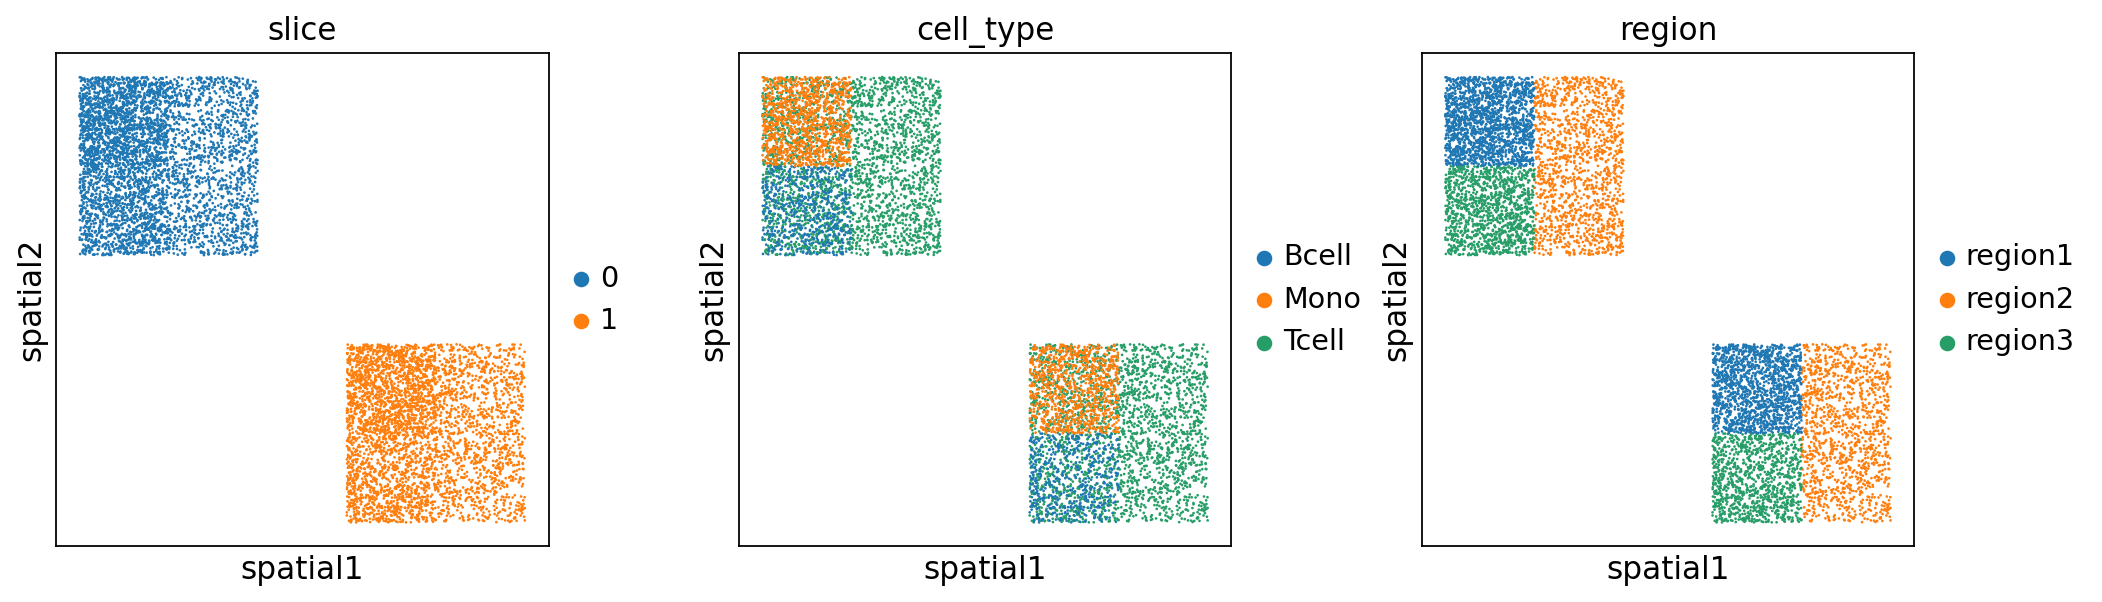

In [4]:
sc.pl.spatial(adata, color=['slice', 'cell_type', 'region'], spot_size=0.03, wspace=0.25)

In [5]:
adata = gex_embedding(adata)

2025-07-11 15:54:19.446 | INFO     | decipher.utils:gex_embedding:527 - Gene expression embedding...
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/flash/grp/gglab/xiacr/DECIPHER-dev/decipher/utils.py:597: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc_.tl.leiden(adata, resolution=resolution)


Then we check the batch effects between slices. We can see that the batch effects are significant.

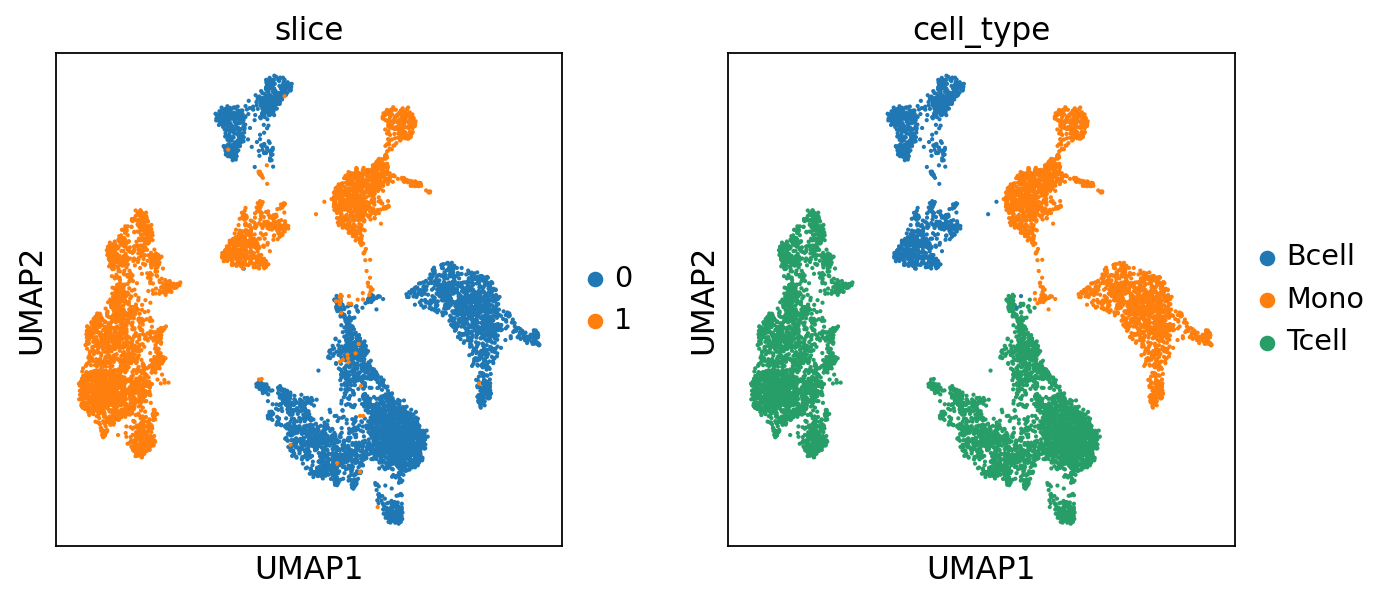

In [6]:
sc.pl.umap(adata, color=['slice', 'cell_type'])

## Step 2: Run DECIPHER

We input a list of Anndata objects, each one is a spaital slices. `DECIPHER` will automatically view each object as one batch and remove the batch effects.

> If you do not want to remove batch effects, just import the CFG by `from decipher import CFG` and  set `CFG.omics.ignore_batch = True`

In [7]:
# Init model
model = DECIPHER(work_dir='./decipher_multi_slices')

# Reload the slices
slice1 = sc.read_h5ad('./slice1.h5ad')
slice2 = sc.read_h5ad('./slice2.h5ad')

# Register the slices
model.register_data([slice1, slice2])

# Run model
model.fit_omics()

2025-07-11 15:55:20.612 | WARNING  | decipher.cls:__init__:47 - decipher_multi_slices already exists but `recover` is False.
2025-07-11 15:55:20.650 | SUCCESS  | decipher.utils:global_seed:330 - Global seed set to 0.
2025-07-11 15:55:22.773 | DEBUG    | decipher.data.process:omics_data_process:68 - adata 0 has 4512 cells, 31915 genes.
2025-07-11 15:55:22.776 | DEBUG    | decipher.data.process:omics_data_process:68 - adata 1 has 3893 cells, 31915 genes.
/flash/grp/gglab/xiacr/DECIPHER-dev/decipher/data/process.py:77: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key="_batch", uns_merge="same")
2025-07-11 15:55:23.789 | INFO     | decipher.data.process:omics_data_process:86 - Input: 2 slice(s) with 8405 cells and 2 batches.
2025-07-11 15:55:23.809 | INFO     | 

Training: |          | 0/? [00:00<?, ?it/s]

Metric train/total_loss improved. New best score: 8.640
Metric train/total_loss improved by 0.238 >= min_delta = 0.0. New best score: 8.402
Metric train/total_loss improved by 0.693 >= min_delta = 0.0. New best score: 7.709
Metric train/total_loss improved by 0.243 >= min_delta = 0.0. New best score: 7.465
Metric train/total_loss improved by 0.131 >= min_delta = 0.0. New best score: 7.334
`Trainer.fit` stopped: `max_steps=192` reached.
2025-07-11 15:57:22.991 | SUCCESS  | decipher.nn.trainer:fit:112 - Train finished in 57.01s.


Testing: |          | 0/? [00:00<?, ?it/s]

2025-07-11 15:57:25.100 | INFO     | decipher.cls:fit_omics:175 - Results saved to decipher_multi_slices


## Step 3: Visualize results

Finally, we visualize the results. We can see that the batch effects are removed, while cell types and spatial regions are well separated.

In [8]:
adata = slice1.concatenate(slice2, batch_key='slice')
adata.obsm['X_center'] = model.center_emb
adata.obsm['X_nbr'] = model.nbr_emb
adata = scanpy_viz(adata, ['center', 'nbr'], rapids=False)

/tmp/ipykernel_2528240/768322786.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = slice1.concatenate(slice2, batch_key='slice')


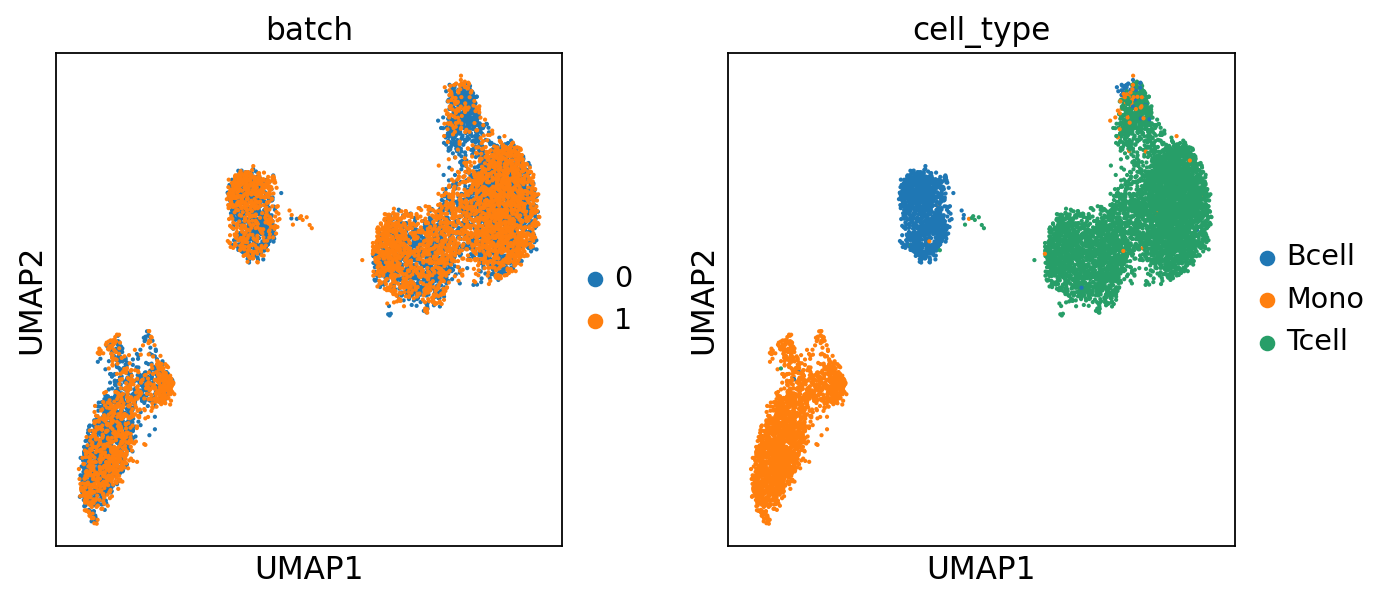

In [9]:
adata.obsm['X_umap'] = adata.obsm['X_umap_center'].copy()
sc.pl.umap(adata, color=['batch', 'cell_type'])

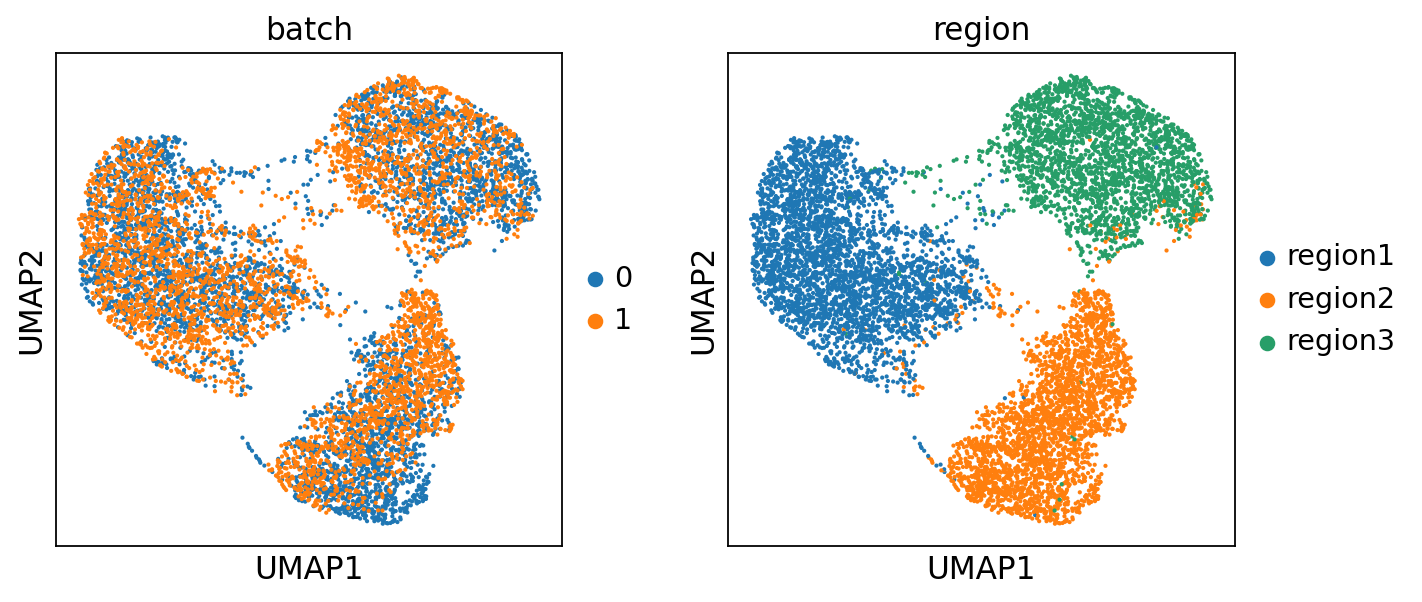

In [10]:
adata.obsm['X_umap'] = adata.obsm['X_umap_nbr'].copy()
sc.pl.umap(adata, color=['batch', 'region'])